In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datapath = "Data"
figurepath = "Figures"

In [2]:
df = pd.read_csv(os.path.join(datapath, "data.csv"))
df = df[df["Study design"] != "Non random"]
df["Seroprotection"] = df["Seroprotection no. (%)"].str.replace(r"\(.*\)","")

In [3]:
weightGroup = ["Normal", "Non-obese", "Overweight", "Overweight/obese", "Obese", "Morbid obese"]

In [4]:
ageColor = {
    "Adults": "#1E90FF",
    "Healthcare workers": "#191970",
    "Military Adults": "#0000FF",
    "Teenagers": "#87CEFA",
    "Children": "#008000",
    "Elder": "#FF0000"
}

In [5]:
# Extract the H1N1 portion of data for trivalent vaccine so to be compared with H1N1 monovalent vaccine
h1n1 = df[(df["Vaccine strain"] == "H1N1") | (df["Vaccine strain"] == "trivalent")]

In [6]:
weightVSprotect = h1n1[["Subject", "Weight group", "Sample size", "Seroprotection"]].dropna()
weightVSprotect["Seroprotection"] = weightVSprotect["Seroprotection"].astype(int)
weightVSprotect = weightVSprotect[weightVSprotect["Weight group"] != "Underweight"]
weightVSprotect["Weight group"] = pd.Categorical(weightVSprotect["Weight group"], categories=weightGroup)
weightVSprotect = weightVSprotect.groupby(["Subject", "Weight group"])
weightVSprotect = weightVSprotect.agg({"Sample size": "sum", "Seroprotection": "sum"}).reset_index()

In [7]:
weightVSadverse = h1n1[["Subject", "Weight group", "Sample size", "System adverse no."]].dropna()
weightVSadverse["System adverse no."] = weightVSadverse["System adverse no."].astype(int)
weightVSadverse = weightVSadverse[weightVSadverse["Weight group"] != "Underweight"]
weightVSadverse["Weight group"] = pd.Categorical(weightVSadverse["Weight group"], categories=weightGroup)
weightVSadverse = weightVSadverse.groupby(["Subject", "Weight group"])
weightVSadverse = weightVSadverse.agg({"Sample size": "sum", "System adverse no.": "sum"}).reset_index()

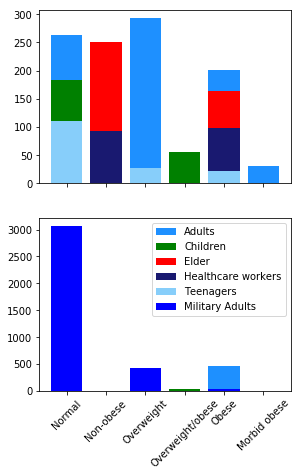

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize = (4.5, 7))
x_pos = np.arange(len(weightGroup))

for i in weightVSprotect["Subject"].unique():
    subgroup = weightVSprotect[weightVSprotect["Subject"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[0].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=ageColor[i]
    )
    
axes[1].bar(x_pos, np.zeros(len(weightGroup)))
for i in weightVSadverse["Subject"].unique():
    subgroup = weightVSadverse[weightVSadverse["Subject"] == i]
    subgroup = subgroup.set_index("Weight group")
    axes[1].bar(x_pos, subgroup["Sample size"], label=i, color=ageColor[i])

handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
    
plt.xticks(x_pos, weightGroup, rotation=45)
plt.legend(handles, labels, loc='upper right')
plt.savefig(os.path.join(figurepath, "age.pdf"), bbox_inches="tight")
plt.show()

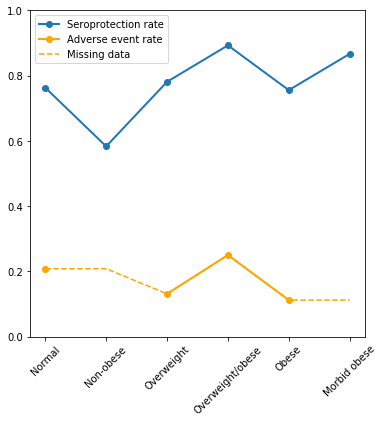

In [18]:
plt.figure(figsize=(6, 6))

groupByWeight = weightVSprotect.groupby("Weight group").agg({"Sample size": "sum", "Seroprotection": "sum"})
groupByWeight["Seroprotection rate"] = groupByWeight["Seroprotection"] / groupByWeight["Sample size"]
groupByWeight = groupByWeight.reindex(weightGroup)

x_pos = np.arange(len(groupByWeight))

plt.plot(x_pos, groupByWeight["Seroprotection rate"], "-o", lw=2, label = "Seroprotection rate")
plt.xticks(x_pos, groupByWeight.index.values, rotation=45)
plt.ylim(0,1)

groupByWeight = weightVSadverse.groupby("Weight group").agg({"Sample size": "sum", "System adverse no.": "sum"})
groupByWeight["AE rate"] = groupByWeight["System adverse no."] / groupByWeight["Sample size"]
groupByWeight = groupByWeight.reindex(["Normal", "Non-obese", "Overweight", "Overweight/obese", "Obese", "Morbid obese"])

plt.plot(x_pos, groupByWeight["AE rate"], "-o", color="orange", lw=2, label="Adverse event rate")
plt.plot(x_pos, groupByWeight["AE rate"].fillna(method="ffill"), "--", color="orange", label="Missing data")

plt.legend()
plt.savefig(os.path.join(figurepath, "comparison.pdf"), bbox_inches="tight")
plt.show()